In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mmctools.plotting import TaylorDiagram

# Taylor Diagram Example

In [2]:
lidar_dpath = 'data'
test_period = ('2019-12-26 06:00', '2019-12-26 09:00')
ref_channel = 'lidar_ws_80' # ~hub-height wind speed

In [3]:
figdir = 'figures'
os.makedirs(figdir,exist_ok=True)

## load lidar data
from https://github.com/NREL/FieldCampaign

In [4]:
# from FieldCampaign import database as fdb
# connect = fdb.Database()

# %time df_hist = connect.get_data_from_db_1min('2019-01-01','2019-12-31')
# # CPU times: user 2min 22s, sys: 2min 4s, total: 4min 27s
# # Wall time: 4min 48s

# df_hist = df_hist.drop_duplicates()
# lidarcolumns = [col for col in df_hist.columns if col.startswith('lidar')]
# lidar = df_hist.set_index('time')[lidarcolumns]

# os.makedirs(lidar_dpath, exist_ok=True)
# lidar = lidar.loc[(lidar.index >= test_period[0]) & (lidar.index <= test_period[1])]
# lidar.to_csv(os.path.join(lidar_dpath,'test_period.csv'))

In [5]:
# load existing data
lidar = pd.read_csv(os.path.join(lidar_dpath,'test_period.csv'),parse_dates=['time']).set_index('time')

In [6]:
ref = lidar[ref_channel]
times = ref.index

In [7]:
trend = ref.resample('10min').mean().resample('1min').pad()

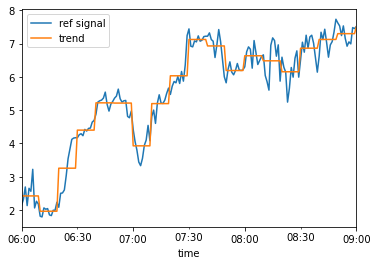

In [8]:
ref.plot(label='ref signal')
trend.plot(label='trend')
plt.legend()

<AxesSubplot:xlabel='time'>

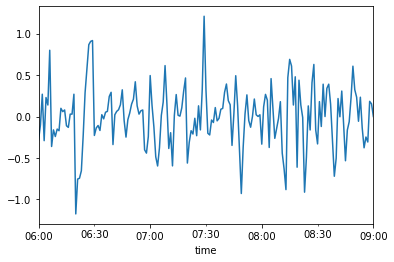

In [9]:
detrended = ref - trend
detrended.plot()

## set up example signals

In [10]:
cases = {}

In [11]:
cases['offset -1'] = ref - 1
cases['offset +2'] = ref + 2

In [12]:
cases['same trend, out of phase'] = trend - detrended

In [13]:
cases['scaled trend (x0.5)'] = 0.5*trend + detrended
cases['detrended'] = detrended
cases['scaled trend (x1.5)'] = 1.5*trend + detrended

In [14]:
cases['smooth (10min)'] = ref.rolling('10min').mean()
cases['smooth (30min)'] = ref.rolling('30min').mean()

In [15]:
cases['scaled deviations (x2)'] = trend + 2*detrended
cases['scaled deviations (x5)'] = trend + 5*detrended

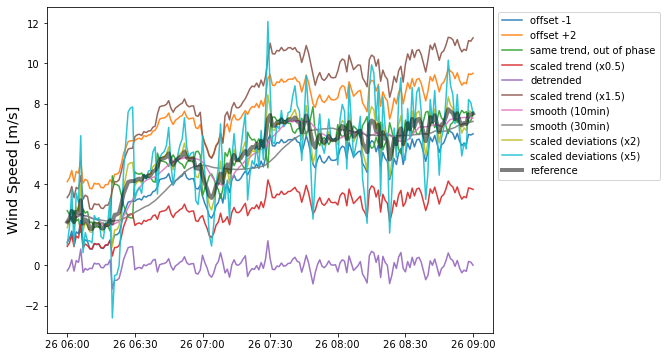

In [16]:
fig,ax = plt.subplots(figsize=(8,6))
for name,case in cases.items():
    ax.plot(times,case,alpha=0.9,label=name)
ax.plot(times, ref, 'k', lw=4, alpha=0.5, label='reference')
ax.legend(loc='upper left',bbox_to_anchor=(1,1))
ax.set_ylabel('Wind Speed [m/s]',fontsize='x-large')
 
fig.savefig(os.path.join(figdir,'sample_timeseries_all.png'),bbox_inches='tight')

## plot taylor diagram

offset -1 1.6596032719471923 0.9999999999999998
offset +2 1.6596032719471923 0.9999999999999998
same trend, out of phase 1.6596032719471925 0.8176456934804448
scaled trend (x0.5) 0.8874004198018256 0.960137425253008
detrended 0.3631505656519526 0.04788118445467085
scaled trend (x1.5) 2.4560718391190117 0.9947961774937394
smooth (10min) 1.6600263924008285 0.9194468172545579
smooth (30min) 1.657033986122775 0.7915899348841081
scaled deviations (x2) 1.7748008396036512 0.960137425253008
scaled deviations (x5) 2.4329741100673106 0.6606017448844861


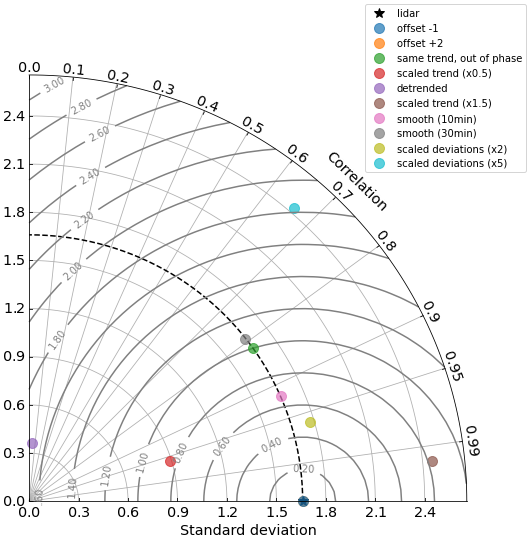

In [17]:
fig = plt.figure(figsize=(8,8))
td = TaylorDiagram(ref.std(), label='lidar', fig=fig,
                   srange=(0,1.6), extend=False,
                   corrticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99],
                   #minorcorrticks=np.arange(0.05,0.9,0.1),
                   #stdevticks=np.arange(0.2,2,0.2),
                   labelsize='x-large')

for name,series in cases.items():
    corr_xy = np.corrcoef(ref, series)[0,1]
    R2 = corr_xy**2
    stdev = series.std()
    print(name,stdev,R2)
    td.add_sample(stdev, R2,
                  marker='o', ms=10, ls='', alpha=0.7,
                  #mfc=color, mec=color,
                  label=name)

# Add grid
td.add_grid()

# Add RMS contours, and label them
contours = td.add_contours(levels=15, colors='0.5')
plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

# Add a figure legend
fig.legend(td.samplePoints,
           [ p.get_label() for p in td.samplePoints ],
           numpoints=1, prop=dict(size='medium'), loc='upper right')

fig.savefig(os.path.join(figdir,'TD_example_all.png'),bbox_inches='tight')

## selected plots

In [18]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [19]:
def make_plots(suffix,selected=[]):
    fig,ax = plt.subplots(figsize=(8,6))
    for i,(name,case) in enumerate(cases.items()):
        if name not in selected: continue
        ax.plot(times,case,color=colors[i],alpha=0.9,label=name)
    ax.plot(times, ref, 'k', lw=4, alpha=0.5, label='reference')
    ax.legend(loc='upper left',bbox_to_anchor=(1,1))
    ax.set_ylabel('Wind Speed [m/s]',fontsize='x-large')
    fig.savefig(os.path.join(figdir,f'sample_timeseries_{suffix}.png'),bbox_inches='tight')
    
    fig = plt.figure(figsize=(8,8))
    td = TaylorDiagram(ref.std(), label='lidar', fig=fig,
                       srange=(0,1.6), extend=False,
                       corrticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99],
                       labelsize='x-large')
    for i,(name,series) in enumerate(cases.items()):
        if name not in selected: continue
        corr_xy = np.corrcoef(ref, series)[0,1]
        R2 = corr_xy**2
        stdev = series.std()
        print(name,stdev,R2)
        td.add_sample(stdev, R2,
                      marker='o', ms=10, ls='', alpha=0.7,
                      mfc=colors[i], mec=colors[i],
                      label=name)
    td.add_grid()
    contours = td.add_contours(levels=15, colors='0.5')
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')
    fig.legend(td.samplePoints,
               [ p.get_label() for p in td.samplePoints ],
               numpoints=1, prop=dict(size='medium'), loc='upper right')
    fig.savefig(os.path.join(figdir,f'TD_example_{suffix}.png'),bbox_inches='tight')

In [20]:
# make_plots('samestdev',selected=['smooth (10min)','smooth (30min)','same trend, out of phase'])
# make_plots('samecorr',selected=['detrended','scaled trend (x0.5)','scaled trend (x1.5)'])
# make_plots('addnoise',selected=['scaled deviations (x2)','scaled deviations (x5)'])